# Comparação entre SVM e Redes Neurais MLP na Classificação de Tumores de Câncer de Mama

In [28]:
#imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, make_scorer, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import warnings

# Suprimir todos os warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# Carregando o dataset
breast_cancer_data = load_breast_cancer()
data = pd.DataFrame(breast_cancer_data.data, columns=breast_cancer_data.feature_names)
data['diagnosis'] = breast_cancer_data.target
data['diagnosis'] = data['diagnosis'].map({0: 'B', 1: 'M'})

In [3]:
X = data.drop(columns=["diagnosis"])
y = data["diagnosis"].map({"B": 0, "M": 1})

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
# Características a primeira Coluna referencia a identificação (ID)
out = f'''
Conjuntos de Dados: O dataset contém {len(data.columns)- 1}  atributos relacionados a características
celulares, como textura, perímetro e simetria.
'''
print(out)


Conjuntos de Dados: O dataset contém 30  atributos relacionados a características
celulares, como textura, perímetro e simetria.



In [5]:
# Treinamento do modelo
svm = SVC(kernel='rbf', C=1, gamma=0.01, class_weight='balanced')
svm.fit(X_train, y_train)


# Avaliação
y_pred_svm = svm.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, zero_division=1))

Acurácia: 0.631578947368421
              precision    recall  f1-score   support

           0       0.50      0.02      0.03        63
           1       0.63      0.99      0.77       108

    accuracy                           0.63       171
   macro avg       0.57      0.50      0.40       171
weighted avg       0.58      0.63      0.50       171



In [6]:
# Configuração e treinamento do MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Avaliação
y_pred_mlp = mlp.predict(X_test)
print("Acurácia MLP:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))

Acurácia MLP: 0.9590643274853801
              precision    recall  f1-score   support

           0       0.98      0.90      0.94        63
           1       0.95      0.99      0.97       108

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



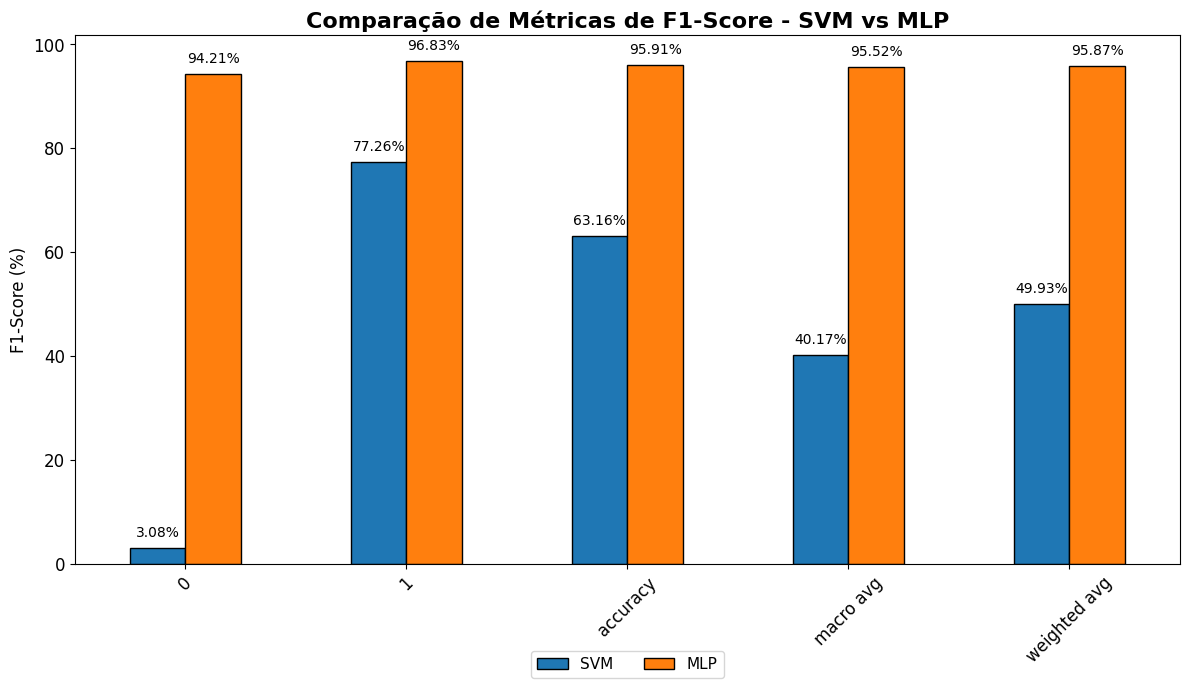

In [7]:
# Obter o classification report para ambos os modelos
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
report_mlp = classification_report(y_test, y_pred_mlp, output_dict=True)

# Convertendo em DataFrame para facilitar a visualização
df_svm = pd.DataFrame(report_svm).T
df_mlp = pd.DataFrame(report_mlp).T

# Multiplicando por 100 e arredondando para duas casas decimais (valores numéricos)
df_comparison = pd.DataFrame({
    'SVM': df_svm['f1-score'].round(4) * 100,
    'MLP': df_mlp['f1-score'].round(4) * 100
})

# Plotando as barras com cores diferentes
ax = df_comparison.plot(kind='bar', figsize=(12, 7), color=['#1f77b4', '#ff7f0e'], edgecolor='black')

# Adicionando título e rótulos
plt.title("Comparação de Métricas de F1-Score - SVM vs MLP", fontsize=16, weight='bold')
plt.ylabel("F1-Score (%)", fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adicionando os valores nas barras, com o símbolo '%' no rótulo
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:.2f}%' for x in container.datavalues], fontsize=10, padding=6)

# Ajustando a legenda para a parte inferior
ax.legend(['SVM', 'MLP'], loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=11)

# Ajustando o layout para melhor visualização
plt.tight_layout()

# Exibir o gráfico
plt.show()

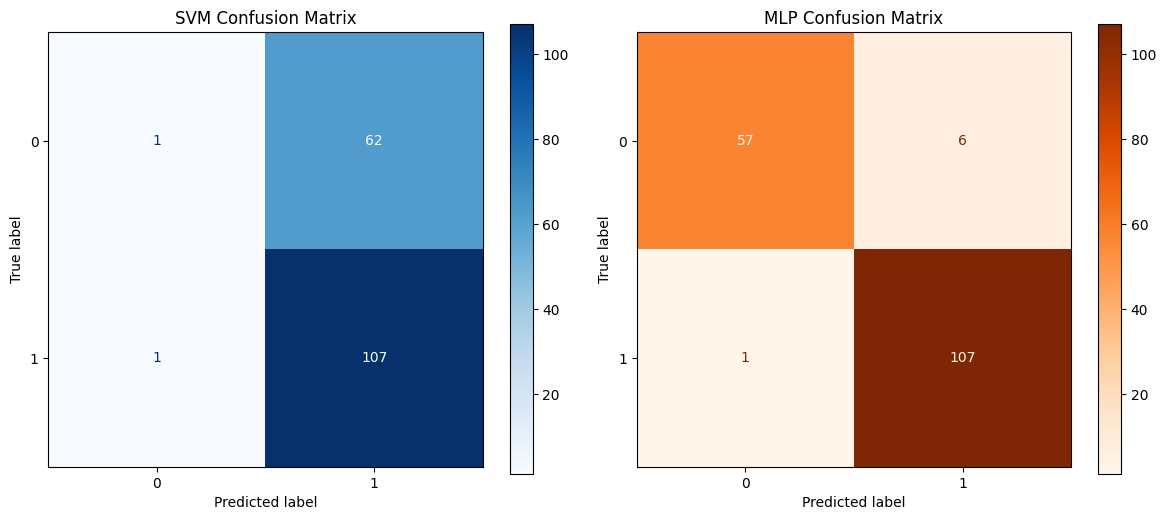

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusão para SVM
disp_svm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, ax=axes[0], cmap='Blues')
axes[0].set_title("SVM Confusion Matrix")

# Matriz de confusão para MLP
disp_mlp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp, ax=axes[1], cmap='Oranges')
axes[1].set_title("MLP Confusion Matrix")

# Exibir o gráfico
plt.tight_layout()
plt.show()

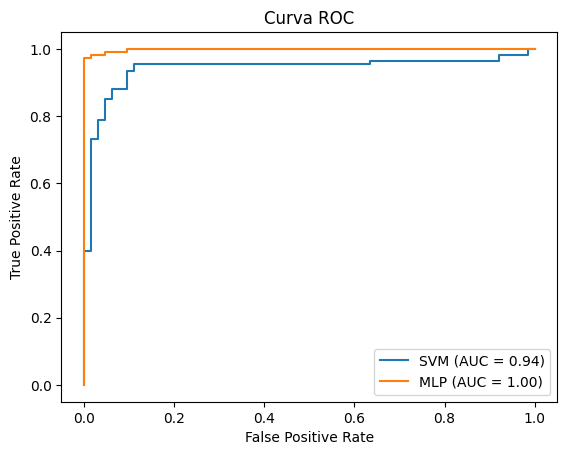

In [9]:
# Curva ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm.decision_function(X_test))
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp.predict_proba(X_test)[:, 1])

plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc(fpr_svm, tpr_svm):.2f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc(fpr_mlp, tpr_mlp):.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

In [10]:
# Definir o conjunto de parâmetros a serem otimizados
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

# Criar o modelo SVM
svm = SVC(class_weight='balanced')

# Aplicar GridSearchCV para otimizar os parâmetros
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Melhor combinação de parâmetros
print("Melhores parâmetros:", grid_search.best_params_)

# Melhor modelo após a otimização
best_svm = grid_search.best_estimator_

# Avaliar o modelo otimizado
y_pred_svm = best_svm.predict(X_test)
print("Acurácia SVM otimizado:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, zero_division=1))

Melhores parâmetros: {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
Acurácia SVM otimizado: 0.9532163742690059
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        63
           1       0.98      0.94      0.96       108

    accuracy                           0.95       171
   macro avg       0.95      0.96      0.95       171
weighted avg       0.95      0.95      0.95       171



In [11]:
# Definir o conjunto de parâmetros a serem otimizados
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000]
}

# Criar o modelo MLP
mlp = MLPClassifier(random_state=42)

# Aplicar GridSearchCV para otimizar os parâmetros
grid_search_mlp = GridSearchCV(mlp, param_grid_mlp, cv=5, scoring='accuracy')
grid_search_mlp.fit(X_train, y_train)

# Melhor combinação de parâmetros
print("Melhores parâmetros para MLP:", grid_search_mlp.best_params_)

# Melhor modelo após a otimização
best_mlp = grid_search_mlp.best_estimator_

# Avaliar o modelo otimizado
y_pred_mlp = best_mlp.predict(X_test)
print("Acurácia MLP otimizado:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))


Melhores parâmetros para MLP: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}
Acurácia MLP otimizado: 0.9883040935672515
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        63
           1       0.98      1.00      0.99       108

    accuracy                           0.99       171
   macro avg       0.99      0.98      0.99       171
weighted avg       0.99      0.99      0.99       171



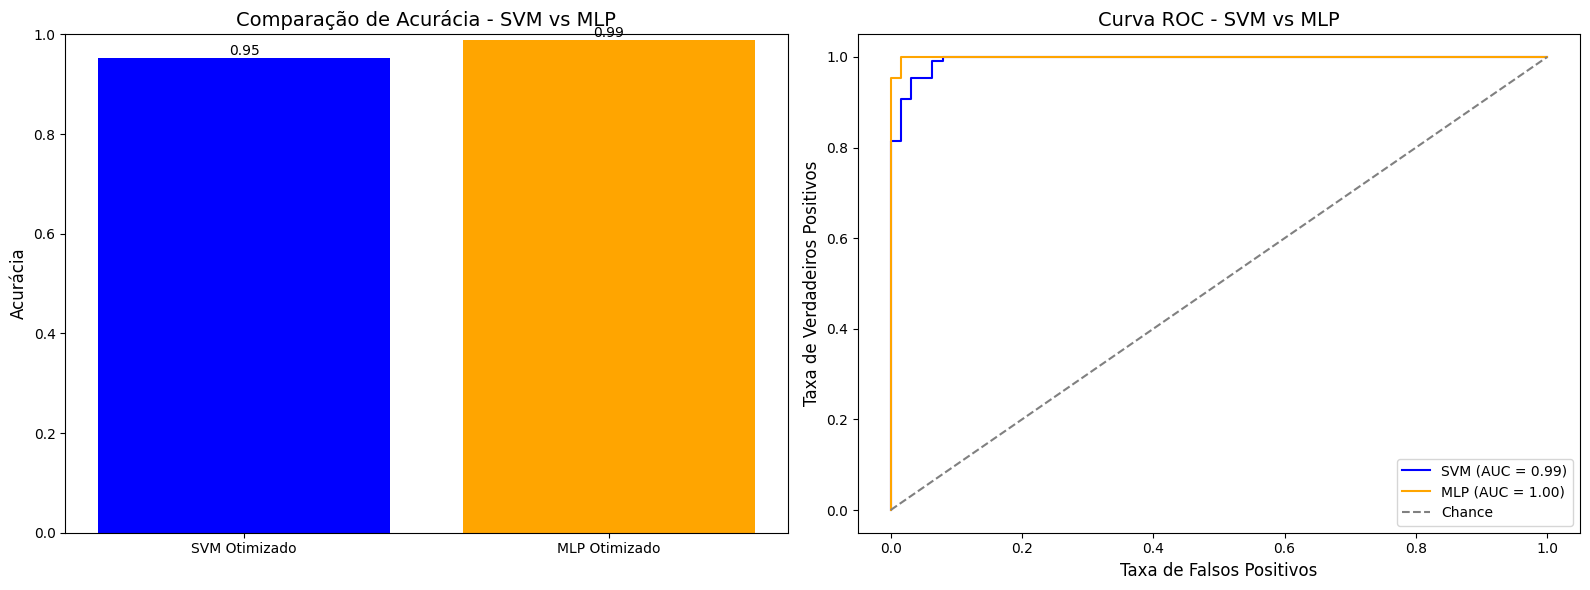

In [12]:
accuracies = [accuracy_score(y_test, y_pred_svm), accuracy_score(y_test, y_pred_mlp)]
models = ['SVM Otimizado', 'MLP Otimizado']

# Curva ROC para SVM otimizado
fpr_svm, tpr_svm, _ = roc_curve(y_test, best_svm.decision_function(X_test))
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Curva ROC para MLP otimizado
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, best_mlp.predict_proba(X_test)[:, 1])
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Criando os gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de Acurácia
bars = axes[0].bar(models, accuracies, color=['blue', 'orange'])
axes[0].set_title("Comparação de Acurácia - SVM vs MLP", fontsize=14)
axes[0].set_ylabel("Acurácia", fontsize=12)
axes[0].set_ylim(0, 1)

# Adicionando rótulos às barras
for bar in bars:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# Gráfico de Curva ROC
axes[1].plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})', color='blue')
axes[1].plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {roc_auc_mlp:.2f})', color='orange')
axes[1].plot([0, 1], [0, 1], 'k--', label='Chance', color='gray')
axes[1].set_xlabel('Taxa de Falsos Positivos', fontsize=12)
axes[1].set_ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
axes[1].set_title('Curva ROC - SVM vs MLP', fontsize=14)
axes[1].legend(loc='lower right')

# Ajustar o layout
plt.tight_layout()

# Exibir os gráficos
plt.show()


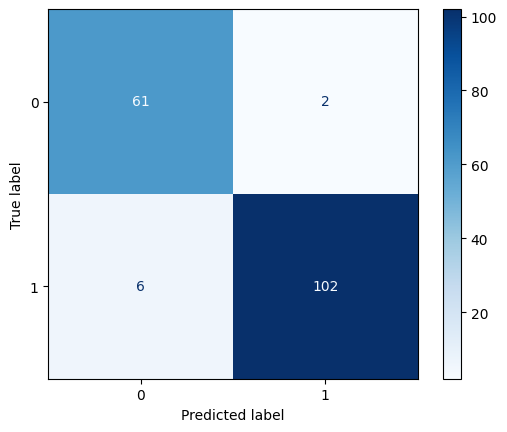

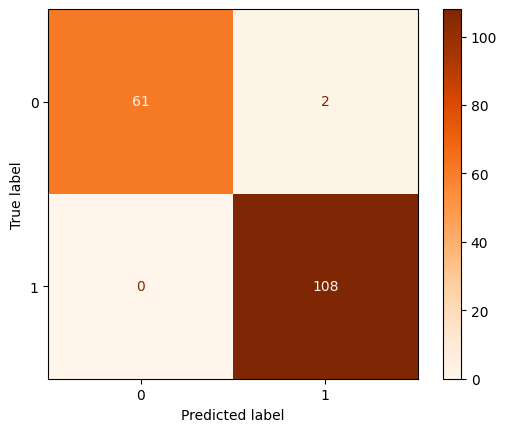

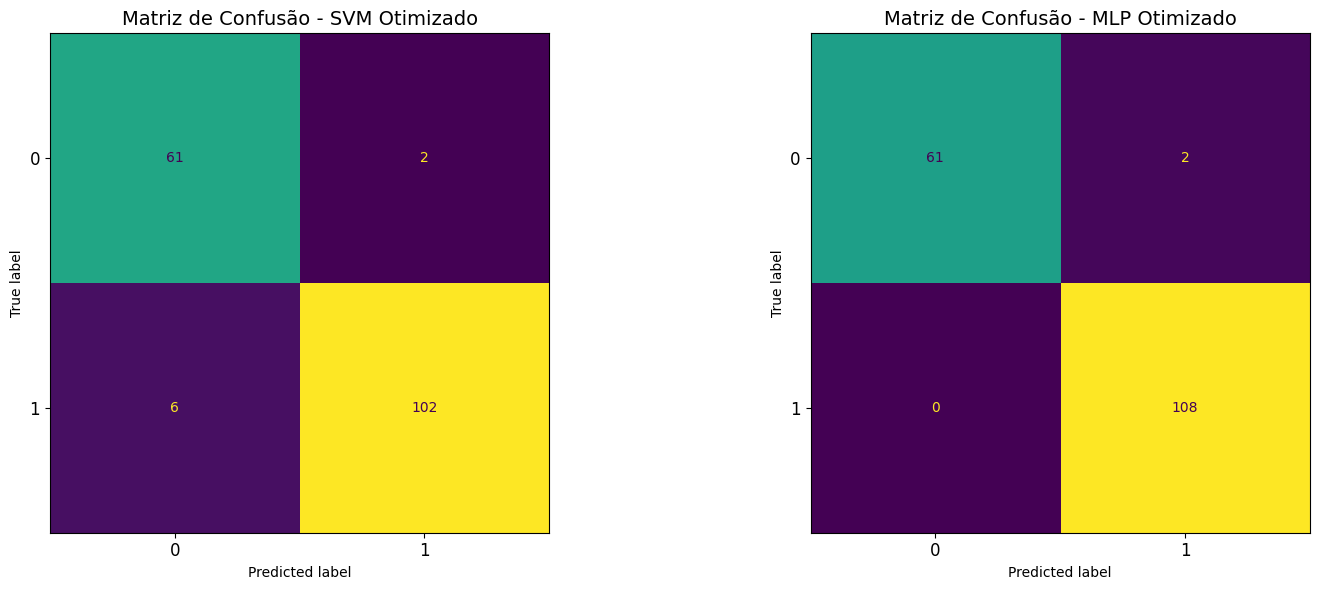

In [13]:
# Matriz de Confusão para SVM otimizado
disp_svm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, cmap='Blues')

# Matriz de Confusão para MLP otimizado
disp_mlp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp, cmap='Oranges')

# Plotando as matrizes de confusão
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# SVM
disp_svm.plot(ax=axes[0], values_format='d', colorbar=False)
axes[0].set_title("Matriz de Confusão - SVM Otimizado", fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)

# MLP
disp_mlp.plot(ax=axes[1], values_format='d', colorbar=False)
axes[1].set_title("Matriz de Confusão - MLP Otimizado", fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)

# Melhorar a aparência geral
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

# Exibir o gráfico
plt.show()

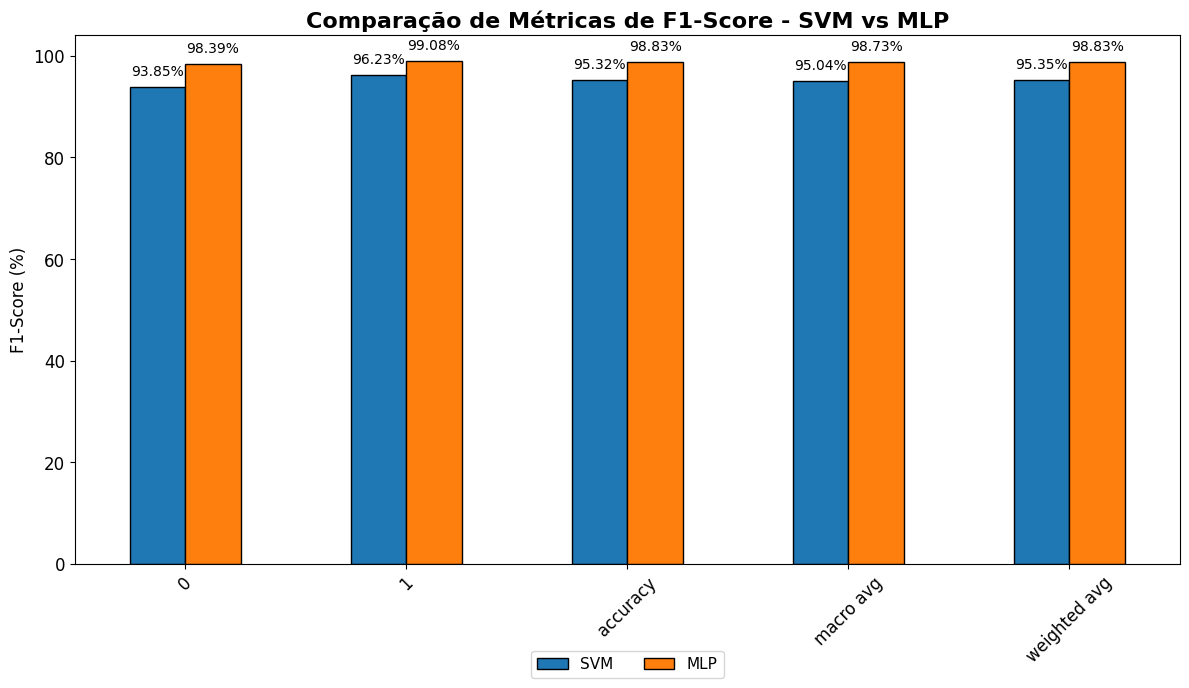

In [14]:
# Obter o classification report para ambos os modelos
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
report_mlp = classification_report(y_test, y_pred_mlp, output_dict=True)

# Convertendo em DataFrame para facilitar a visualização
df_svm = pd.DataFrame(report_svm).T
df_mlp = pd.DataFrame(report_mlp).T

# Multiplicando por 100 e arredondando para duas casas decimais (valores numéricos)
df_comparison = pd.DataFrame({
    'SVM': df_svm['f1-score'].round(4) * 100,
    'MLP': df_mlp['f1-score'].round(4) * 100
})

# Plotando as barras com cores diferentes
ax = df_comparison.plot(kind='bar', figsize=(12, 7), color=['#1f77b4', '#ff7f0e'], edgecolor='black')

# Adicionando título e rótulos
plt.title("Comparação de Métricas de F1-Score - SVM vs MLP", fontsize=16, weight='bold')
plt.ylabel("F1-Score (%)", fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adicionando os valores nas barras, com o símbolo '%' no rótulo
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:.2f}%' for x in container.datavalues], fontsize=10, padding=6)

# Ajustando a legenda para a parte inferior
ax.legend(['SVM', 'MLP'], loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=11)

# Ajustando o layout para melhor visualização
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [15]:
# Escalonar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
# Usar os dados escalonados para treinar e testar os modelos
best_svm.fit(X_train_scaled, y_train)


SVC(C=10, class_weight='balanced', gamma=0.001, kernel='linear')

In [17]:
# Usar os dados escalonados para treinar e testar os modelos
best_mlp.fit(X_train_scaled, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(50,), max_iter=500,
              random_state=42)

In [18]:
# Avaliar o SVM otimizado com dados escalonados
y_pred_svm = best_svm.predict(X_test_scaled)
print("Acurácia SVM otimizado com escalonamento:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# Avaliar o MLP otimizado com dados escalonados
y_pred_mlp = best_mlp.predict(X_test_scaled)
print("Acurácia MLP otimizado com escalonamento:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))

Acurácia SVM otimizado com escalonamento: 0.9649122807017544
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        63
           1       0.98      0.96      0.97       108

    accuracy                           0.96       171
   macro avg       0.96      0.97      0.96       171
weighted avg       0.97      0.96      0.97       171

Acurácia MLP otimizado com escalonamento: 0.9766081871345029
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        63
           1       0.98      0.98      0.98       108

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



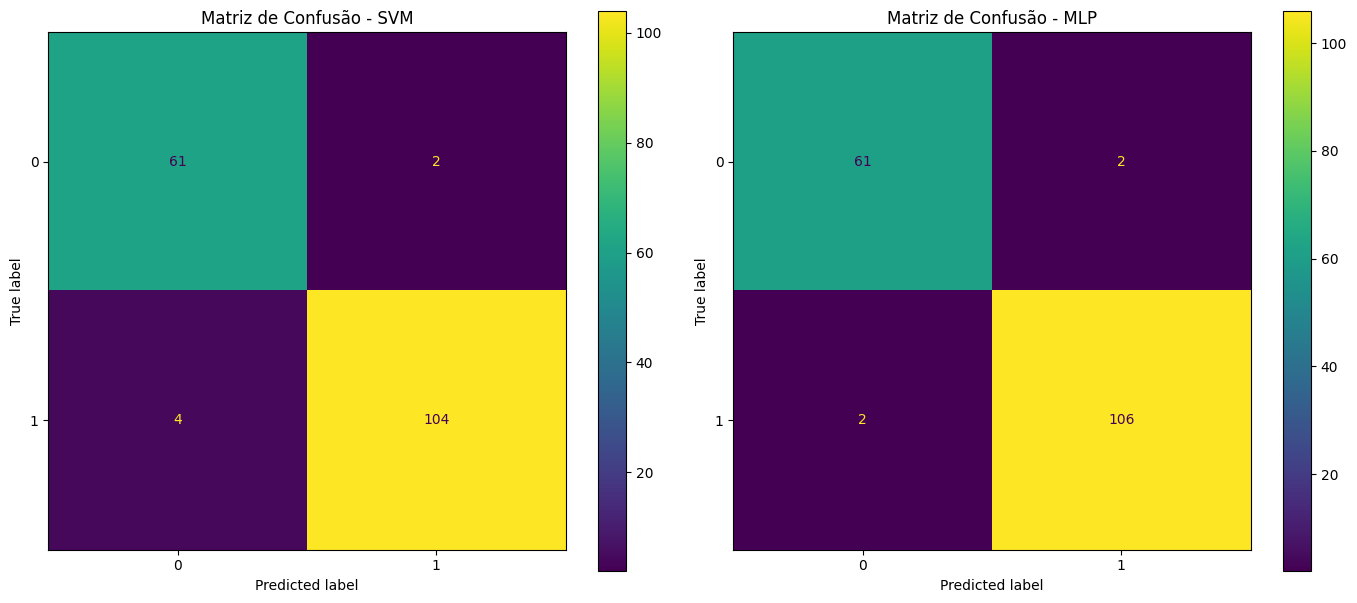

In [19]:
# Calcular as matrizes de confusão
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

# Criar os subgráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Exibir a matriz de confusão do SVM
ConfusionMatrixDisplay(cm_svm).plot(ax=axes[0])
axes[0].set_title('Matriz de Confusão - SVM')

# Exibir a matriz de confusão do MLP
ConfusionMatrixDisplay(cm_mlp).plot(ax=axes[1])
axes[1].set_title('Matriz de Confusão - MLP')

# Ajustar o layout para melhor visualização
plt.tight_layout()

# Exibir os gráficos
plt.show()

In [20]:
# Configuração da Validação Cruzada com 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Validação Cruzada para o SVM otimizado
svm_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=kf, scoring='accuracy')
print("Validação Cruzada SVM - Acurácia média:", svm_scores.mean())
print("Desvio padrão da acurácia SVM:", svm_scores.std())

# Validação Cruzada para o MLP otimizado
mlp_scores = cross_val_score(best_mlp, X_train_scaled, y_train, cv=kf, scoring='accuracy')
print("Validação Cruzada MLP - Acurácia média:", mlp_scores.mean())
print("Desvio padrão da acurácia MLP:", mlp_scores.std())

Validação Cruzada SVM - Acurácia média: 0.9648417721518987
Desvio padrão da acurácia SVM: 0.00931390994387198
Validação Cruzada MLP - Acurácia média: 0.9749050632911394
Desvio padrão da acurácia MLP: 0.019344892965139915


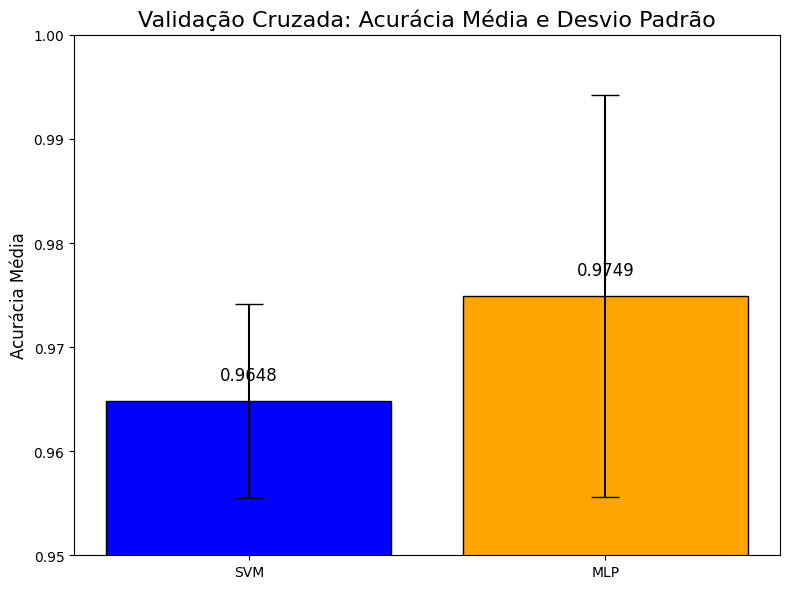

In [21]:
# Dados da validação cruzada
models = ['SVM', 'MLP']
mean_accuracies = [0.9648, 0.9749]  # Acurácia média de cada modelo
std_accuracies = [0.0093, 0.0193]   # Desvio padrão de cada modelo

# Criar gráfico de barras com erro (desvio padrão)
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(models, mean_accuracies, yerr=std_accuracies, capsize=10, color=['blue', 'orange'], edgecolor='black')

# Adicionar título e rótulos
ax.set_title("Validação Cruzada: Acurácia Média e Desvio Padrão", fontsize=16)
ax.set_ylabel("Acurácia Média", fontsize=12)
ax.set_ylim(0.95, 1.0)  # Ajuste da escala para focar nas acurácias

# Adicionar os valores nas barras
for i, v in enumerate(mean_accuracies):
    ax.text(i, v + 0.002, f'{v:.4f}', ha='center', fontsize=12)

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [24]:
# Definir métricas de avaliação
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Validação Cruzada para o SVM otimizado
svm_results = cross_validate(best_svm, X_train_scaled, y_train, cv=5, scoring=scoring, return_train_score=True)

# Validação Cruzada para o MLP otimizado
mlp_results = cross_validate(best_mlp, X_train_scaled, y_train, cv=5, scoring=scoring, return_train_score=True)

# Exibindo Resultados
print("==== SVM Otimizado ====")
print(f"Acurácia média: {svm_results['test_accuracy'].mean():.4f}")
print(f"Precisão média: {svm_results['test_precision'].mean():.4f}")
print(f"Recall médio: {svm_results['test_recall'].mean():.4f}")
print(f"F1-Score médio: {svm_results['test_f1'].mean():.4f}")
print(f"Tempo médio de treino: {svm_results['fit_time'].mean():.4f} segundos")
print(f"Tempo médio de teste: {svm_results['score_time'].mean():.4f} segundos")

print("\n==== MLP Otimizado ====")
print(f"Acurácia média: {mlp_results['test_accuracy'].mean():.4f}")
print(f"Precisão média: {mlp_results['test_precision'].mean():.4f}")
print(f"Recall médio: {mlp_results['test_recall'].mean():.4f}")
print(f"F1-Score médio: {mlp_results['test_f1'].mean():.4f}")
print(f"Tempo médio de treino: {mlp_results['fit_time'].mean():.4f} segundos")
print(f"Tempo médio de teste: {mlp_results['score_time'].mean():.4f} segundos")

==== SVM Otimizado ====
Acurácia média: 0.9698
Precisão média: 0.9703
Recall médio: 0.9698
F1-Score médio: 0.9699
Tempo médio de treino: 0.0051 segundos
Tempo médio de teste: 0.0100 segundos

==== MLP Otimizado ====
Acurácia média: 0.9697
Precisão média: 0.9706
Recall médio: 0.9697
F1-Score médio: 0.9695
Tempo médio de treino: 1.3660 segundos
Tempo médio de teste: 0.0216 segundos


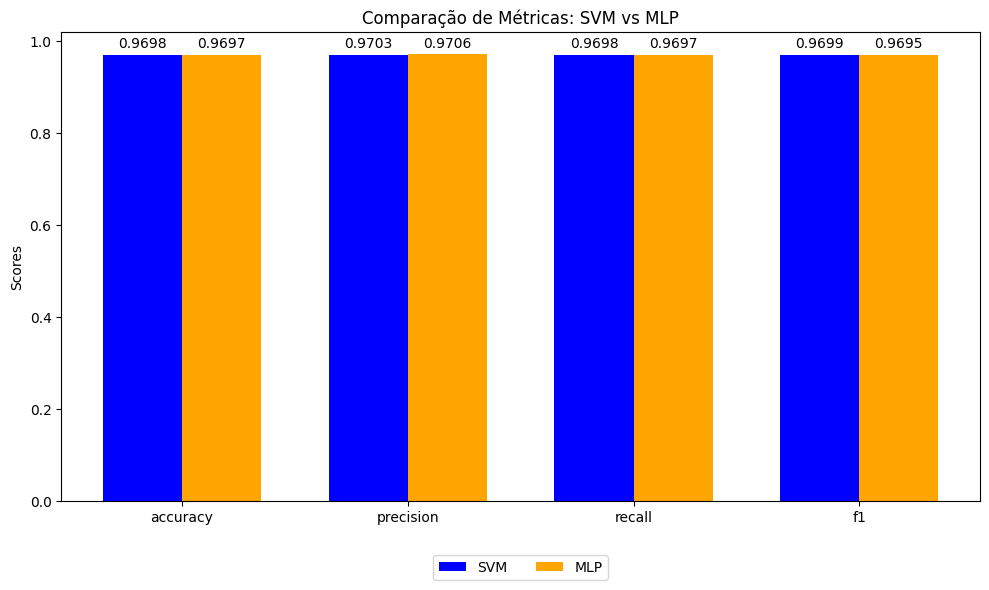

In [27]:

# Extraindo médias dos resultados
svm_metrics = {
    'accuracy': svm_results['test_accuracy'].mean(),
    'precision': svm_results['test_precision'].mean(),
    'recall': svm_results['test_recall'].mean(),
    'f1': svm_results['test_f1'].mean(),
    'fit_time': svm_results['fit_time'].mean(),
    'score_time': svm_results['score_time'].mean()
}

mlp_metrics = {
    'accuracy': mlp_results['test_accuracy'].mean(),
    'precision': mlp_results['test_precision'].mean(),
    'recall': mlp_results['test_recall'].mean(),
    'f1': mlp_results['test_f1'].mean(),
    'fit_time': mlp_results['fit_time'].mean(),
    'score_time': mlp_results['score_time'].mean()
}

# Definindo as métricas para o gráfico
metrics = ['accuracy', 'precision', 'recall', 'f1']

# Criando o gráfico
x = np.arange(len(metrics))  # Localização das barras
width = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(10, 6))

# Barras para SVM
rects1 = ax.bar(x - width/2, list(svm_metrics.values())[:4], width, label='SVM', color='b')

# Barras para MLP
rects2 = ax.bar(x + width/2, list(mlp_metrics.values())[:4], width, label='MLP', color='orange')

# Adicionando rótulos e título
ax.set_ylabel('Scores')
ax.set_title('Comparação de Métricas: SVM vs MLP')
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# Posicionando a legenda na parte inferior
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Função para adicionar o valor das barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Deslocamento do texto
                    textcoords="offset points",
                    ha='center', va='bottom')

# Adicionando as labels
add_labels(rects1)
add_labels(rects2)

# Exibindo o gráfico
plt.tight_layout()
plt.show()